In [75]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.layers import Dense, TimeDistributed
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import layers

## Functions

In [76]:
def df_to_X_y(df, window_size=5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


def load_data(file):
    df = pd.read_csv(file)
    df.drop(columns="Unnamed: 0", inplace= True)
    df = df.set_index("Date")
    return df

def fit_model(model, cp, epochs, xt, yt, xv, yv):
    model.compile(loss=MeanSquaredError(), optimizer=Adam(), metrics=[RootMeanSquaredError()])
    history = model.fit(xt, yt, validation_data=(xv, yv), epochs=epochs, callbacks=[cp], verbose=0)
    return model, history

def save_history(history, fname):
    training_loss = history.history['loss']
    validation_loss = history.history.get('val_loss', None)  # Handle optional key
    training_acc = history.history.get('accuracy', None)  # Handle optional key
    validation_acc = history.history.get('val_accuracy', None)  # Handle optional key

    # Create a dictionary
    history_data = {
        'training_loss': training_loss,
        'validation_loss': validation_loss,
        'training_accuracy': training_acc,
        'validation_accuracy': validation_acc}
    history_df = pd.DataFrame(history_data)
    history_df.to_csv(f"epochs{epochs}/history_{fname}.csv")
    

def plot_val(model,Nsample, xv, yv):
    val_predictions = model.predict(xv).flatten()
    val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':yv})
    plt.plot(val_results['Val Predictions'][:Nsample])
    plt.plot(val_results['Actuals'][:Nsample])
    plt.title("Validation")
    plt.show()
    
def plot_test(model, Nsample, xtt, ytt):
    test_predictions = model.predict(xtt).flatten()
    test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':ytt})
    plt.plot(test_results['Test Predictions'][:Nsample])
    plt.plot(test_results['Actuals'][:Nsample])
    plt.title("Test")
    plt.show()
    
def calculate_nse(observed, predicted):
    assert observed.shape == predicted.shape, "Observed and predicted arrays must have the same shape."
    mean_observed = np.mean(observed)
    numerator = np.sum((observed - predicted) ** 2)
    denominator = np.sum((observed - mean_observed) ** 2)
    nse = 1 - (numerator / denominator)
    return nse


def plot_predictions1(model, X, y, start=0, end=100):
    prediction = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions':prediction, 'Actuals':y})
    plt.plot(df['Predictions'][start:end])
    plt.plot(df['Actuals'][start:end])
    plt.title("Predictions")
    plt.show()
    nse_v = calculate_nse(y, prediction)
    mse_v = mse(y, prediction)
    mae_v = mae(y, prediction)
    r2_v = r2(y, prediction)

    return nse_v, mse_v, mae_v, r2_v



def autoencode_evaluate(model, xt):
    predictions = model.predict(xt)
    predictions_flat = predictions.flatten()
    x_test_flat = xt.flatten()

    nse_v = mse(x_test_flat, predictions_flat)
    mae_v = mae(x_test_flat, predictions_flat)
    r2_v = r2(x_test_flat, predictions_flat)
    return mse_v, mae_v, r2_v

def plot_train_history(history):
    plt.plot(history.history['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title('Training Loss History')
    plt.show()

def plot_train(modelname, Nsample, xt, yt):
    model = load_model(modelname)
    train_predictions = model.predict(xt).flatten()
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':yt})
    plt.plot(train_results['Train Predictions'][:Nsample])
    plt.plot(train_results['Actuals'][:Nsample])
    plt.title("Train")
    plt.show()
    
def load_data_model(epochs):
    x_train = np.load(f"epochs{epochs}/x_train.npy")
    y_train = np.load(f"epochs{epochs}/y_train.npy")
    x_test  = np.load(f"epochs{epochs}/x_test.npy")
    y_test  = np.load(f"epochs{epochs}/y_test.npy")
    x_val   = np.load(f"epochs{epochs}/x_val.npy")
    y_val   = np.load(f"epochs{epochs}/y_val.npy")
    
    return x_train, y_train, x_test, y_test, x_val, y_val

## Import Data

In [77]:
epochs = 50

In [78]:
x_train, y_train, x_test, y_test, x_val, y_val = load_data_model(epochs)

In [79]:
x_train[0]

array([[  26.4 ],
       [   7.96],
       [1808.  ],
       [  32.23],
       [   2.03],
       [  26.8 ],
       [   7.32],
       [1813.  ],
       [  32.4 ],
       [   2.05],
       [  28.57],
       [   7.01],
       [1867.  ],
       [  35.91],
       [   2.74],
       [  28.03],
       [   7.24],
       [1886.  ],
       [  35.67],
       [   2.16],
       [  28.82],
       [   7.21],
       [1888.  ],
       [  37.64],
       [   2.46]])

# General Model

### CNN

In [80]:
model = load_model(f"epochs{epochs}/cnn/")

3/3 [==============================] - 0s 3ms/step


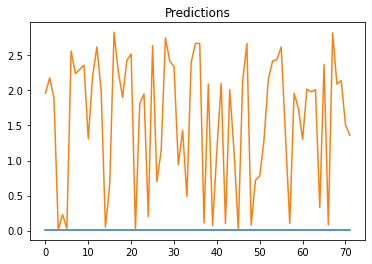

In [81]:
cnn_nse, cnn_mse, cnn_mae, cnn_r2 = plot_predictions1(model, x_test, y_test)

### GRU

In [82]:
model = load_model(f"epochs{epochs}/gru/")

3/3 [==============================] - 1s 20ms/step


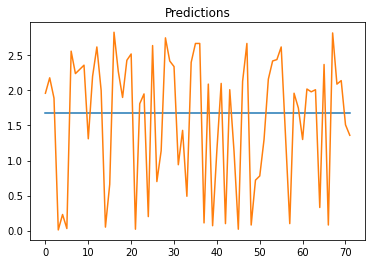

In [83]:
gru_nse, gru_mse, gru_mae, gru_r2 = plot_predictions1(model, x_test, y_test)

### LSTM

In [84]:
model = load_model(f"epochs{epochs}/lstm/")

3/3 [==============================] - 0s 24ms/step


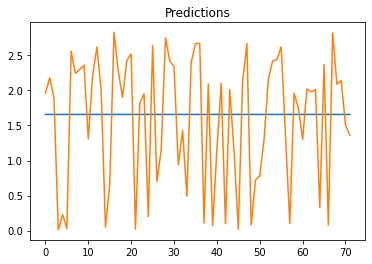

In [85]:
lstm_nse, lstm_mse, lstm_mae, lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN

In [86]:
model = load_model(f"epochs{epochs}/rnn/")

3/3 [==============================] - 0s 3ms/step


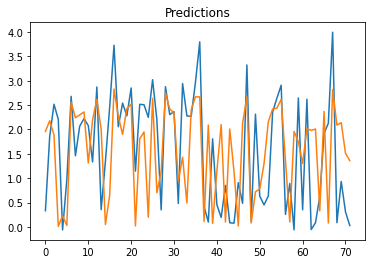

In [87]:
rnn_nse, rnn_mse , rnn_mae, rnn_r2 = plot_predictions1(model, x_test, y_test)

# Moving Average

#### CNN

3/3 [==============================] - 0s 3ms/step


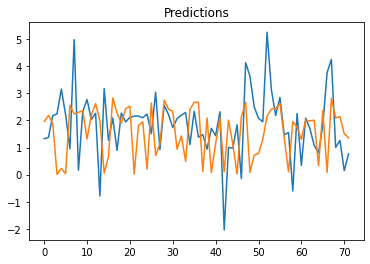

In [88]:
model = load_model(f"epochs{epochs}/mavg_cnn/")
mavg_cnn_nse, mavg_cnn_mse , mavg_cnn_mae, mavg_cnn_r2 = plot_predictions1(model, x_test, y_test)

#### GRU

In [89]:
model = load_model(f"epochs{epochs}/mavg_gru/")

3/3 [==============================] - 0s 5ms/step


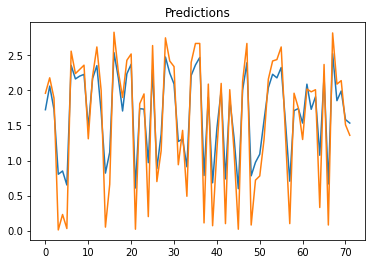

In [90]:
mavg_gru_nse, mavg_gru_mse , mavg_gru_mae, mavg_gru_r2 = plot_predictions1(model, x_test, y_test)

#### LSTM

In [91]:
model = load_model(f"epochs{epochs}/mavg_lstm/")

3/3 [==============================] - 1s 7ms/step


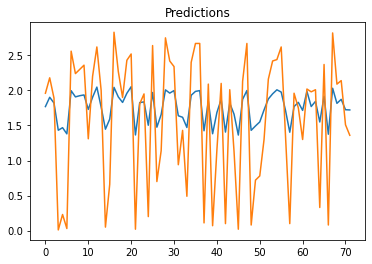

In [92]:
mavg_lstm_nse, mavg_lstm_mse, mavg_lstm_mae, mavg_lstm_r2 = plot_predictions1(model, x_test, y_test)

#### RNN

In [93]:
model = load_model(f"epochs{epochs}/mavg_rnn/")

3/3 [==============================] - 0s 3ms/step


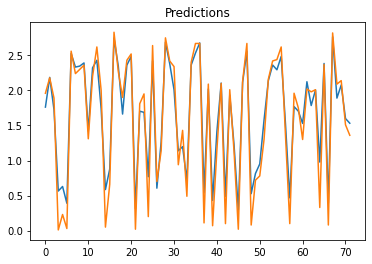

In [94]:
mavg_rnn_nse, mavg_rnn_mse, mavg_rnn_mae, mavg_rnn_r2 = plot_predictions1(model, x_test, y_test)

# AutoEncoder

### CNN

In [95]:
model = load_model(f"epochs{epochs}/autoencoder_cnn/")

3/3 [==============================] - 0s 2ms/step


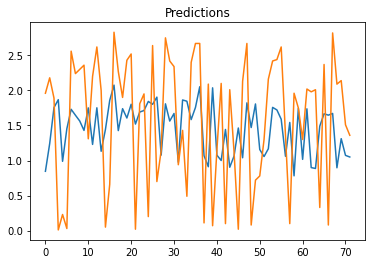

In [96]:
auto_cnn_nse, auto_cnn_mse, auto_cnn_mae, auto_cnn_r2 = plot_predictions1(model, x_test, y_test)

### GRU

In [97]:
model = load_model(f"epochs{epochs}/auto_gru/")

3/3 [==============================] - 0s 4ms/step


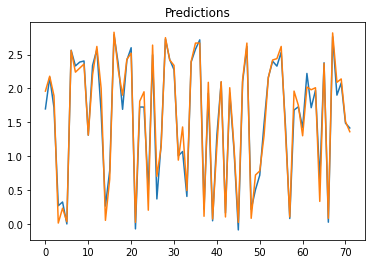

In [98]:
auto_gru_nse, auto_gru_mse, auto_gru_mae, auto_gru_r2 = plot_predictions1(model, x_test, y_test)

### LSTM

In [99]:
model = load_model(f"epochs{epochs}/auto_lstm/")

3/3 [==============================] - 0s 5ms/step


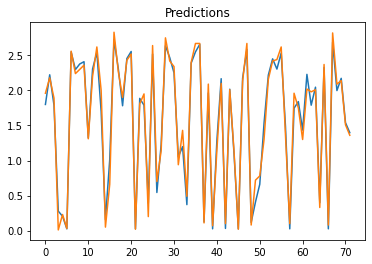

In [100]:
auto_lstm_nse, auto_lstm_mse, auto_lstm_mae, auto_lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN

In [101]:
model = load_model(f"epochs{epochs}/auto_rnn/")

3/3 [==============================] - 0s 3ms/step


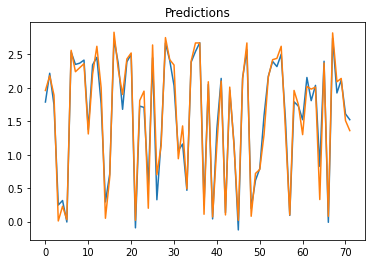

In [102]:
auto_rnn_nse, auto_rnn_mse, auto_rnn_mae, auto_rnn_r2 = plot_predictions1(model, x_test, y_test)

# Moving Average with Encoder

### CNN

In [103]:
model = load_model(f"epochs{epochs}/mavg_auto_cnn/")

3/3 [==============================] - 0s 2ms/step


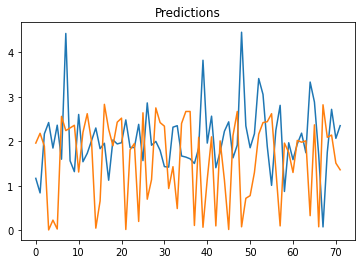

In [104]:
mavg_auto_cnn_nse, mavg_auto_cnn_mse, mavg_auto_cnn_mae, mavg_auto_cnn_r2 = plot_predictions1(model, x_test, y_test)

### RNN

In [105]:
model = load_model(f"epochs{epochs}/mavg_auto_rnn/")

3/3 [==============================] - 0s 3ms/step


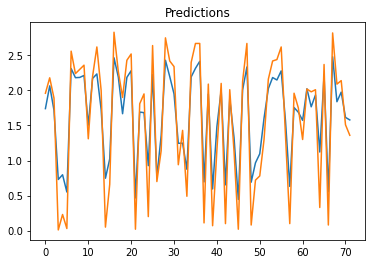

In [106]:
mavg_auto_rnn_nse, mavg_auto_rnn_mse, mavg_auto_rnn_mae, mavg_auto_rnn_r2 = plot_predictions1(model, x_test, y_test)

### GRU

In [107]:
model = load_model(f"epochs{epochs}/mavg_auto_gru/")

3/3 [==============================] - 0s 4ms/step


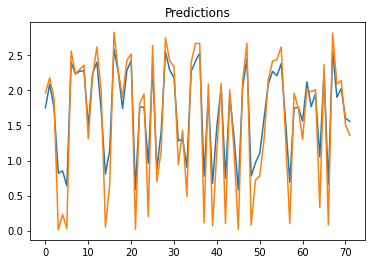

In [108]:
mavg_auto_gru_nse, mavg_auto_gru_mse, mavg_auto_gru_mae, mavg_auto_gru_r2 = plot_predictions1(model, x_test, y_test)

### LSTM

In [109]:
model = load_model(f"epochs{epochs}/mavg_auto_lstm/")

3/3 [==============================] - 0s 4ms/step


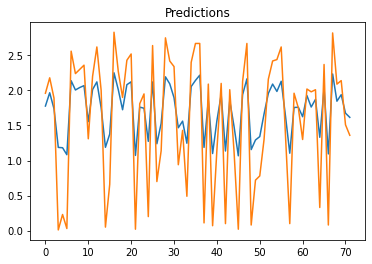

In [110]:
mavg_auto_lstm_nse, mavg_auto_lstm_mse, mavg_auto_lstm_mae, mavg_auto_lstm_r2 = plot_predictions1(model, x_test, y_test)

# Hybrid

## General

### CNN LSTM

In [111]:
model = load_model(f"epochs{epochs}/hybrid_cnn_lstm/")

3/3 [==============================] - 1s 6ms/step


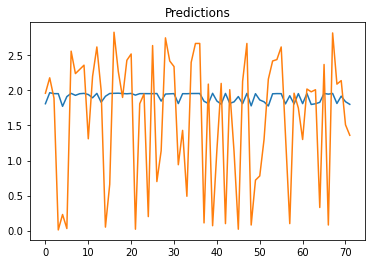

In [112]:
hybrid_cnn_lstm_nse, hybrid_cnn_lstm_mse, hybrid_cnn_lstm_mae, hybrid_cnn_lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN LSTM

In [113]:
model = load_model(f"epochs{epochs}/hybrid_rnn_lstm/")

3/3 [==============================] - 0s 5ms/step


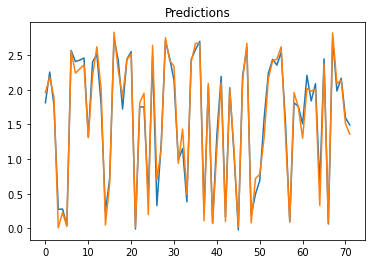

In [114]:
hybrid_rnn_lstm_nse, hybrid_rnn_lstm_mse, hybrid_rnn_lstm_mae, hybrid_rnn_lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN GRU

In [115]:
model = load_model(f"epochs{epochs}/hybrid_rnn_gru/")

3/3 [==============================] - 0s 7ms/step


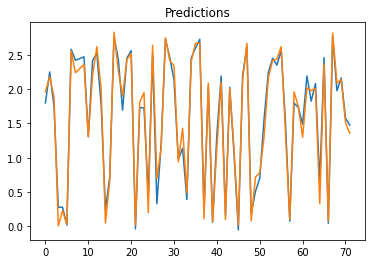

In [116]:
hybrid_rnn_gru_nse, hybrid_rnn_gru_mse, hybrid_rnn_gru_mae, hybrid_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### CNN GRU

In [117]:
model = load_model(f"epochs{epochs}/hybrid_cnn_gru/")

3/3 [==============================] - 0s 6ms/step


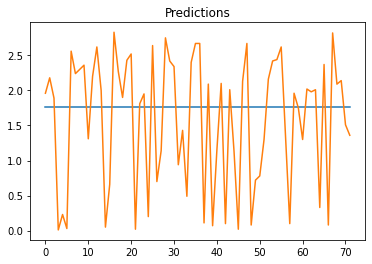

In [118]:
hybrid_cnn_gru_nse, hybrid_cnn_gru_mse, hybrid_cnn_gru_mae, hybrid_cnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### CNN RNN GRU

In [119]:
model = load_model(f"epochs{epochs}/hybrid_cnn_rnn_gru/")

3/3 [==============================] - 0s 5ms/step


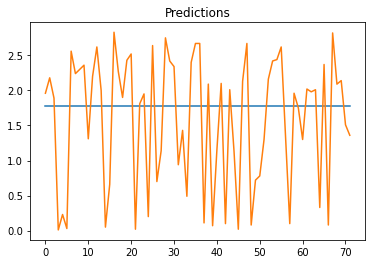

In [120]:
hybrid_cnn_rnn_gru_nse, hybrid_cnn_rnn_gru_mse, hybrid_cnn_rnn_gru_mae, hybrid_cnn_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### LSTM RNN GRU

In [121]:
model = load_model(f"epochs{epochs}/hybrid_lstm_rnn_gru/")

3/3 [==============================] - 1s 9ms/step


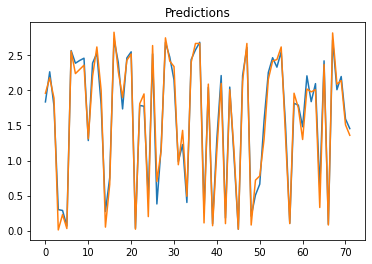

In [122]:
hybrid_lstm_rnn_gru_nse, hybrid_lstm_rnn_gru_mse, hybrid_lstm_rnn_gru_mae, hybrid_lstm_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

## Moving Average

### CNN LSTM

In [123]:
model = load_model(f"epochs{epochs}/mavg_hybrid_cnn_lstm/")

3/3 [==============================] - 1s 6ms/step


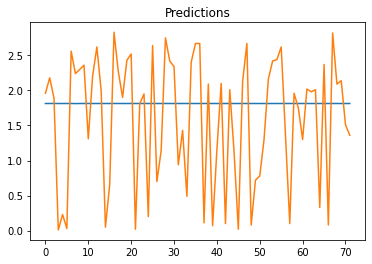

In [124]:
mavg_hybrid_cnn_lstm_nse, mavg_hybrid_cnn_lstm_mse, mavg_hybrid_cnn_lstm_mae, mavg_hybrid_cnn_lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN LSTM

In [125]:
model = load_model(f"epochs{epochs}/mavg_hybrid_rnn_lstm/")

3/3 [==============================] - 0s 5ms/step


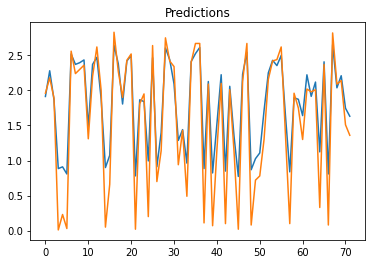

In [126]:
mavg_hybrid_rnn_lstm_nse, mavg_hybrid_rnn_lstm_mse, mavg_hybrid_rnn_lstm_mae, mavg_hybrid_rnn_lstm_r2 = plot_predictions1(model, x_test, y_test)

### RNN GRU

In [127]:
model = load_model(f"epochs{epochs}/mavg_hybrid_rnn_gru/")

3/3 [==============================] - 0s 5ms/step


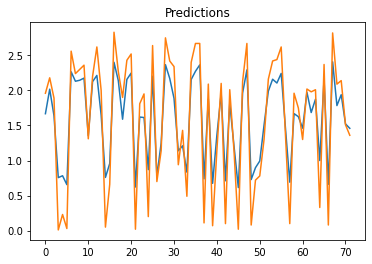

In [128]:
mavg_hybrid_rnn_gru_nse, mavg_hybrid_rnn_gru_mse, mavg_hybrid_rnn_gru_mae, mavg_hybrid_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### CNN GRU

In [129]:
model = load_model(f"epochs{epochs}/mavg_hybrid_cnn_gru/")

3/3 [==============================] - 1s 6ms/step


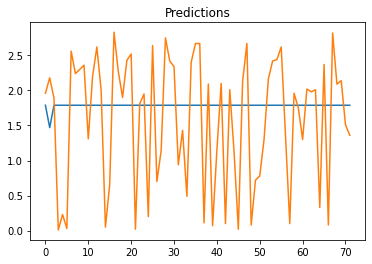

In [130]:
mavg_hybrid_cnn_gru_nse, mavg_hybrid_cnn_gru_mse, mavg_hybrid_cnn_gru_mae, mavg_hybrid_cnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### CNN RNN GRU

In [131]:
model = load_model(f"epochs{epochs}/mavg_hybrid_cnn_rnn_gru/")

3/3 [==============================] - 0s 5ms/step


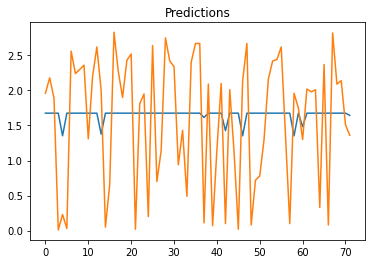

In [132]:
mavg_hybrid_cnn_rnn_gru_nse, mavg_hybrid_cnn_rnn_gru_mse, mavg_hybrid_cnn_rnn_gru_mae, mavg_hybrid_cnn_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

### RNN LSTM GRU

In [133]:
model = load_model(f"epochs{epochs}/mavg_hybrid_lstm_rnn_gru/")

3/3 [==============================] - 1s 12ms/step


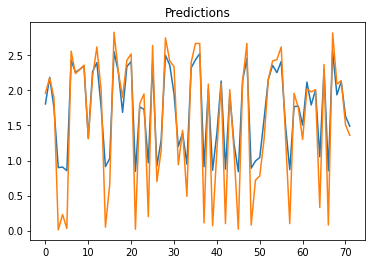

In [134]:
mavg_hybrid_lstm_rnn_gru_nse, mavg_hybrid_lstm_rnn_gru_mse, mavg_hybrid_lstm_rnn_gru_mae, mavg_hybrid_lstm_rnn_gru_r2 = plot_predictions1(model, x_test, y_test)

# MSE

In [135]:
gen = ["General" for _ in range(0,4)]
ma = ["MA" for _ in range(0,4)]
ae = ["DReg" for _ in range(0,4)]
ma_ae = ["MA DReg" for _ in range(0,4)]
hy = ["HY" for _ in range(0,6)]
ma_hy = ["MA HY" for _ in range(0,6)]

model_cat = []
for a in gen:
    model_cat.append(a)
for a in ma:
    model_cat.append(a)
for a in ae:
    model_cat.append(a)
for a in ma_ae:
    model_cat.append(a)
for a in hy:
    model_cat.append(a)
for a in ma_hy:
    model_cat.append(a)

<AxesSubplot:xlabel='Model'>

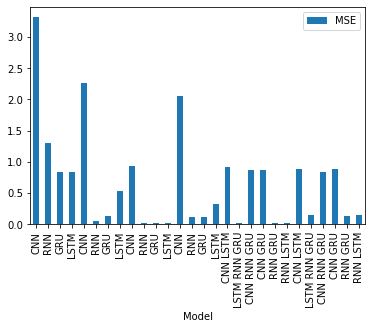

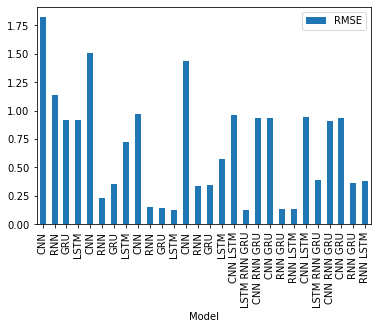

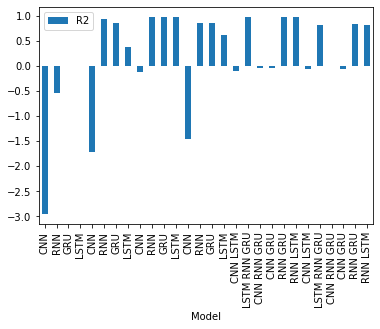

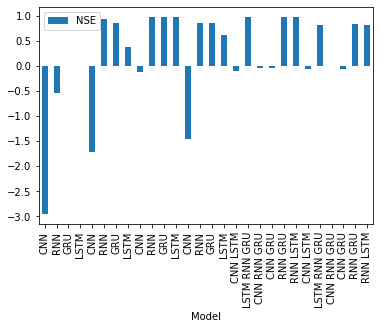

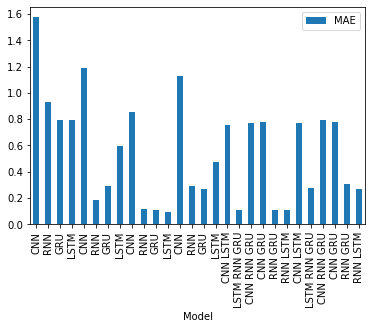

In [146]:
mse_list = [cnn_mse, rnn_mse, gru_mse, lstm_mse,
            mavg_cnn_mse, mavg_rnn_mse, mavg_gru_mse, mavg_lstm_mse,
            auto_cnn_mse, auto_rnn_mse, auto_gru_mse, auto_lstm_mse,
            mavg_auto_cnn_mse, mavg_auto_rnn_mse, mavg_auto_gru_mse, mavg_auto_lstm_mse,
            hybrid_cnn_lstm_mse, hybrid_lstm_rnn_gru_mse,hybrid_cnn_rnn_gru_mse,hybrid_cnn_gru_mse,
            hybrid_rnn_gru_mse,hybrid_rnn_lstm_mse,
            mavg_hybrid_cnn_lstm_mse, mavg_hybrid_lstm_rnn_gru_mse,mavg_hybrid_cnn_rnn_gru_mse,
            mavg_hybrid_cnn_gru_mse,mavg_hybrid_rnn_gru_mse,mavg_hybrid_rnn_lstm_mse]

nse_list = [cnn_nse, rnn_nse, gru_nse, lstm_nse,
            mavg_cnn_nse, mavg_rnn_nse, mavg_gru_nse, mavg_lstm_nse,
            auto_cnn_nse, auto_rnn_nse, auto_gru_nse, auto_lstm_nse,
            mavg_auto_cnn_nse, mavg_auto_rnn_nse, mavg_auto_gru_nse, mavg_auto_lstm_nse,
            hybrid_cnn_lstm_nse, hybrid_lstm_rnn_gru_nse,hybrid_cnn_rnn_gru_nse,hybrid_cnn_gru_nse,
            hybrid_rnn_gru_nse,hybrid_rnn_lstm_nse,
            mavg_hybrid_cnn_lstm_nse, mavg_hybrid_lstm_rnn_gru_nse,mavg_hybrid_cnn_rnn_gru_nse,
            mavg_hybrid_cnn_gru_nse,mavg_hybrid_rnn_gru_nse,mavg_hybrid_rnn_lstm_nse]


mae_list = [cnn_mae, rnn_mae, gru_mae, lstm_mae,
            mavg_cnn_mae, mavg_rnn_mae, mavg_gru_mae, mavg_lstm_mae,
            auto_cnn_mae, auto_rnn_mae, auto_gru_mae, auto_lstm_mae,
            mavg_auto_cnn_mae, mavg_auto_rnn_mae, mavg_auto_gru_mae, mavg_auto_lstm_mae,
            hybrid_cnn_lstm_mae, hybrid_lstm_rnn_gru_mae,hybrid_cnn_rnn_gru_mae,hybrid_cnn_gru_mae,
            hybrid_rnn_gru_mae,hybrid_rnn_lstm_mae,
            mavg_hybrid_cnn_lstm_mae, mavg_hybrid_lstm_rnn_gru_mae,mavg_hybrid_cnn_rnn_gru_mae,
            mavg_hybrid_cnn_gru_mae,mavg_hybrid_rnn_gru_mae,mavg_hybrid_rnn_lstm_mae]

r2_list = [cnn_r2, rnn_r2, gru_r2, lstm_r2,
            mavg_cnn_r2, mavg_rnn_r2, mavg_gru_r2, mavg_lstm_r2,
            auto_cnn_r2, auto_rnn_r2, auto_gru_r2, auto_lstm_r2,
            mavg_auto_cnn_r2, mavg_auto_rnn_r2, mavg_auto_gru_r2, mavg_auto_lstm_r2,
            hybrid_cnn_lstm_r2, hybrid_lstm_rnn_gru_r2,hybrid_cnn_rnn_gru_r2,hybrid_cnn_gru_r2,
            hybrid_rnn_gru_r2,hybrid_rnn_lstm_r2,
            mavg_hybrid_cnn_lstm_r2, mavg_hybrid_lstm_rnn_gru_r2,mavg_hybrid_cnn_rnn_gru_r2,
            mavg_hybrid_cnn_gru_r2,mavg_hybrid_rnn_gru_r2,mavg_hybrid_rnn_lstm_r2]


model_n = ["CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN", "RNN", "GRU", "LSTM",
           "CNN LSTM", "LSTM RNN GRU" ,"CNN RNN GRU","CNN GRU",
           "RNN GRU","RNN LSTM",
           "CNN LSTM", "LSTM RNN GRU","CNN RNN GRU",
           "CNN GRU","RNN GRU","RNN LSTM"
          ]


metricsdf = pd.DataFrame({
    "Model Category": model_cat,
    "Model": model_n,
    "NSE": nse_list,
    "MSE": mse_list,
    "MAE": mae_list,
    "R2": r2_list
})

rmse = np.sqrt(metricsdf.MSE)
metricsdf["RMSE"] = rmse

metricsdf.plot("Model", "MSE", kind= "bar")
metricsdf.plot("Model", "RMSE", kind= "bar")
metricsdf.plot("Model", "R2", kind= "bar")
metricsdf.plot("Model", "NSE", kind= "bar")
metricsdf.plot("Model", "MAE", kind= "bar")

In [137]:
metricsdf.drop(columns= "MSE", inplace = True)

In [138]:
metricsdf

,Model Category,Model,NSE,MAE,R2,RMSE
0,General,CNN,-2.963575,1.574988,-2.963575,1.821303
1,General,RNN,-0.547005,0.933067,-0.547005,1.137849
2,General,GRU,-0.008017,0.790700,-0.008017,0.918486
3,General,LSTM,-0.005486,0.792904,-0.005486,0.917332
4,MA,CNN,-1.713353,1.187114,-1.713353,1.506925
5,MA,RNN,0.934226,0.181438,0.934226,0.234620
6,MA,GRU,0.848955,0.291575,0.848955,0.355542
7,MA,LSTM,0.369973,0.596292,0.369973,0.726136
8,DReg,CNN,-0.115341,0.851612,-0.115341,0.966146
9,DReg,RNN,0.971881,0.117610,0.971881,0.153406


In [139]:
metricsdf.to_csv(f"epochs{epochs}/metricsT.csv", index= False)

In [140]:
metricsdf

,Model Category,Model,NSE,MAE,R2,RMSE
0,General,CNN,-2.963575,1.574988,-2.963575,1.821303
1,General,RNN,-0.547005,0.933067,-0.547005,1.137849
2,General,GRU,-0.008017,0.790700,-0.008017,0.918486
3,General,LSTM,-0.005486,0.792904,-0.005486,0.917332
4,MA,CNN,-1.713353,1.187114,-1.713353,1.506925
5,MA,RNN,0.934226,0.181438,0.934226,0.234620
6,MA,GRU,0.848955,0.291575,0.848955,0.355542
7,MA,LSTM,0.369973,0.596292,0.369973,0.726136
8,DReg,CNN,-0.115341,0.851612,-0.115341,0.966146
9,DReg,RNN,0.971881,0.117610,0.971881,0.153406


In [141]:
nse = metricsdf.NSE
mae = metricsdf.MAE
r2 = metricsdf.R2
rmse = metricsdf.RMSE

In [142]:
l_nse = ["NSE" for _ in range(0,28)]

msedf = pd.DataFrame({
    "Metrics": l_nse,
    "Model Category": metricsdf["Model Category"],
    "Model": metricsdf.Model,
    "y": nse
})


l_mae = ["MAE" for _ in range(0,28)]

maedf = pd.DataFrame({
    "Metrics": l_mae,
    "Model Category": metricsdf["Model Category"],
    "Model": metricsdf.Model,
    "y": mae
})


l_rmse = ["RMSE" for _ in range(0,28)]

rmsedf = pd.DataFrame({
    "Metrics": l_rmse,
    "Model Category": metricsdf["Model Category"],
    "Model": metricsdf.Model,
    "y": rmse
})


l_r2 = ["R2" for _ in range(0,28)]

r2df = pd.DataFrame({
    "Metrics": l_r2,
    "Model Category": metricsdf["Model Category"],
    "Model": metricsdf.Model,
    "y": r2
})

In [143]:
metrics = pd.concat([msedf, rmsedf, maedf, r2df])

In [144]:
metrics

,Metrics,Model Category,Model,y
0,NSE,General,CNN,-2.963575
1,NSE,General,RNN,-0.547005
2,NSE,General,GRU,-0.008017
3,NSE,General,LSTM,-0.005486
4,NSE,MA,CNN,-1.713353
...,...,...,...,...
23,R2,MA HY,LSTM RNN GRU,0.821113
24,R2,MA HY,CNN RNN GRU,0.005910
25,R2,MA HY,CNN GRU,-0.053511
26,R2,MA HY,RNN GRU,0.843138


In [145]:
metrics.to_csv(f"epochs{epochs}/metrics.csv", index= False)